# Tracking Code

# Importations

In [1]:
import sys

In [2]:
import os
os.environ.setdefault("OMP_NUM_THREADS","1") # export OMP_NUM_THREADS=1
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1") # export OPENBLAS_NUM_THREADS=1
os.environ.setdefault("MKL_NUM_THREADS","1") # export MKL_NUM_THREADS=1
os.environ.setdefault("VECLIB_MAXIMUM_THREADS","1") # export VECLIB_MAXIMUM_THREADS=1
os.environ.setdefault("NUMEXPR_NUM_THREADS","1") # export NUMEXPR_NUM_THREADS=1

'1'

In [3]:
import os
import subprocess
import glob

In [4]:
import wraplorenzmie

In [5]:
from wraplorenzmie.pylorenzmie.utilities import azimedian, azistd

In [6]:
%matplotlib widget
import ipywidgets as widgets

In [7]:
import wraplorenzmie.utilities.utilities as utilities

import wraplorenzmie.fits.fit as fit
#import imageio
# For Plotting.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#sns.set(style='white', font_scale=2)
%matplotlib inline
import matplotlib as mpl


mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["lines.markeredgecolor"] = "k"
mpl.rcParams["lines.markeredgewidth"] = 0.1
mpl.rcParams["figure.dpi"] = 130
from matplotlib import rc
rc('font', family='serif')
rc('text', usetex=False)
rc('xtick', labelsize='medium')
rc('ytick', labelsize='medium')

def cm2inch(value):
    return value/2.54

INFO:configuration: CATCH deselected in /home/brownianxgames/miniconda3/envs/pylorenzmie-2/lib/python3.10/site-packages/pylorenzmie/utilities/configuration.py
INFO:configuration: Falling back to standard implementation


Using Cupy


In [8]:
from scipy.io import savemat

# Inputs

In [9]:
# Calibration (um/px)
calib = 0.05799
# Wavelength of the illumination (must be in um)
wavelength = 0.532
# Acquisition framerate
fps = 50
# Liquid's medium
n_m = 1.33

In [10]:
# Filename for the video
filename = glob.glob("*.mp4")[0]

In [11]:
foldername = os.path.basename(os.getcwd())
foldername

'6'

In [12]:
# filename_trimmed = filename[:-4] + "_trimmed_start_at_5min.mp4"

# from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
# ffmpeg_extract_subclip(filename, 5*60, 1000*60, targetname=filename_trimmed[:])

In [13]:
# filename = filename_trimmed

In [14]:
filename

'Basler_acA1920-155um__22392621__20240723_121841626.mp4'

In [15]:
# Create the python's object (class) corresponding to the video
vid = utilities.video_reader(filename)

In [16]:
# Get the number of images in the video
cmd = r"ffprobe -v error -select_streams v:0 -count_packets -show_entries stream=nb_read_packets -of csv=p=0 " + filename
nb_image = int(subprocess.check_output(cmd, shell=True))
nb_image

149433

In [17]:
# Uncomment next box if an error occurs and enter the number of images manually

In [18]:
# nb_image = 10000
# nb_image

In [19]:
# The previous box should be upgraded with a try-except combo

In [20]:
# Update vid
vid.number = nb_image

In [21]:
# Change if you want to start at something else than first frame
n_start = 0

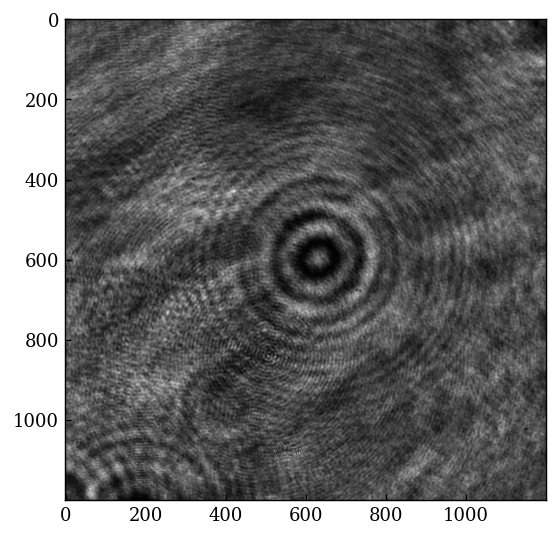

In [22]:
# Get first image and plot
image = vid.get_image(n_start)
plt.imshow(image,cmap="gray")

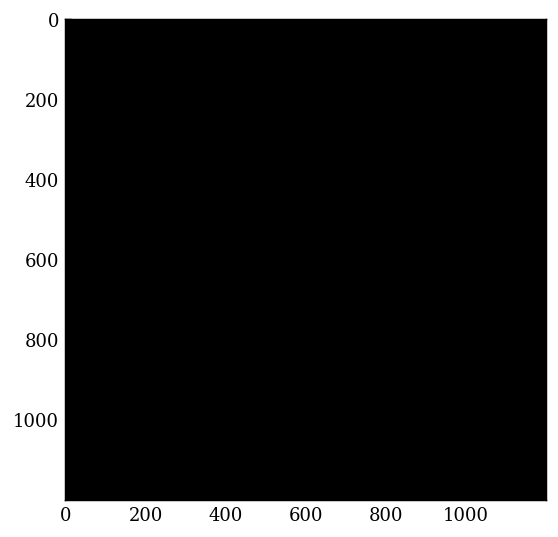

In [23]:
# Compute the background of the video
# The current method won't work for gliding: TO BE DISCUSSED
# buf, background = vid.get_background(40)
background = np.ones_like(image)* np.mean(image)
vid.background = background
plt.imshow(vid.background,cmap="gray")

In [24]:
#imageio.imwrite("background"+generic_output_name+".tiff", vid.background)

In [25]:
# No zeros in the bg
vid.background[vid.background == 0] = 1  

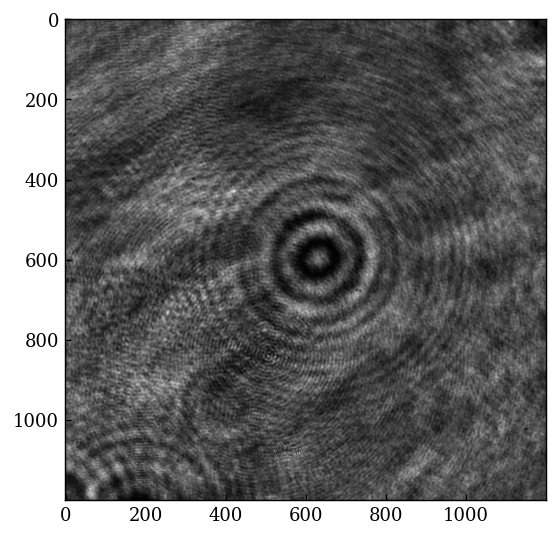

In [26]:
# Normalize first image and plot
normed_image = utilities.normalize(image, vid.background)
plt.imshow(normed_image, cmap="gray")
# normed_image = normed_image

In [27]:
# Find the center of the hologram 
feature = utilities.center_find(normed_image)
feature

[{'x_p': 509.4198914375766,
  'y_p': 837.7097706181054,
  'bbox': ((421, 750), 175, 175)}]

In [28]:
# Uncomment next box if nothing was found and enter approximate position manually

In [34]:
feature = [{}]

feature[0]["x_p"] = 625
feature[0]["y_p"] = 600
feature[0]["bbox"] = [200, 200, 200]

In [35]:
x, a, b = feature[0]["bbox"]

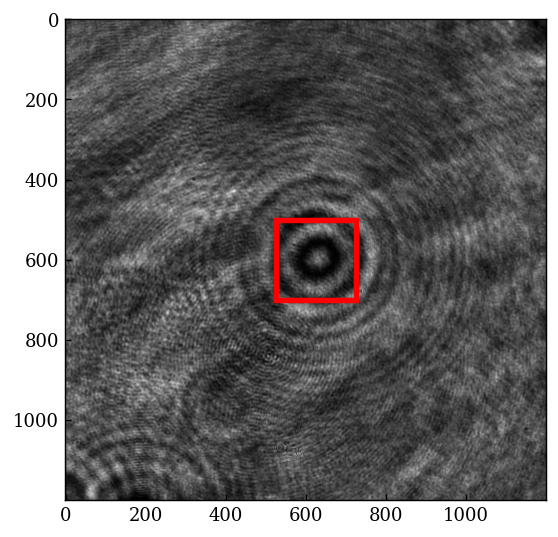

In [36]:
utilities.plot_bounding(normed_image,feature)

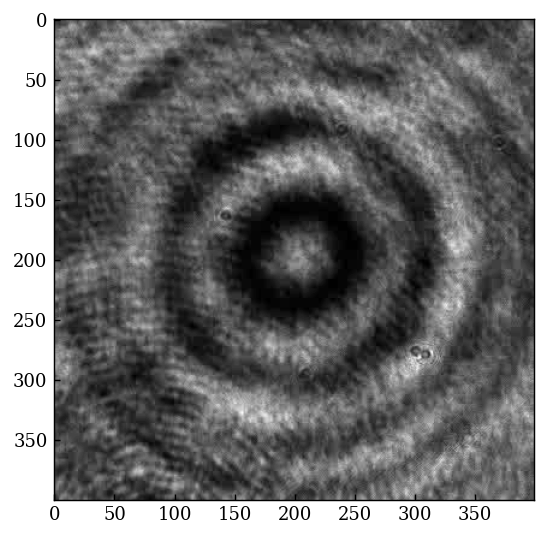

In [38]:
# More precision on the center determination
i = 0 # index of the hologram wanted
x, y, w, h = [feature[i]['x_p'], feature[i]['y_p'],*feature[i]["bbox"][1:]]
x = x +3
y = y 
x_center = x
y_center = y
h = 400 # box size
im_c = fit.crop(image, int(x), int(y), int(h))
bk_c = fit.crop(vid.background, int(x), int(y), int(h))
cropped = utilities.normalize(im_c,bk_c, dark_count = np.min(im_c))
# cropped = im_c
plt.imshow(cropped,cmap = "gray")

In [39]:
# Define the fitting class
fitter = fit.fitting(cropped, wavelength, calib, n_m = n_m, percentpix=1, mask="fast", double_precision=True)
# fitter.show_mask()

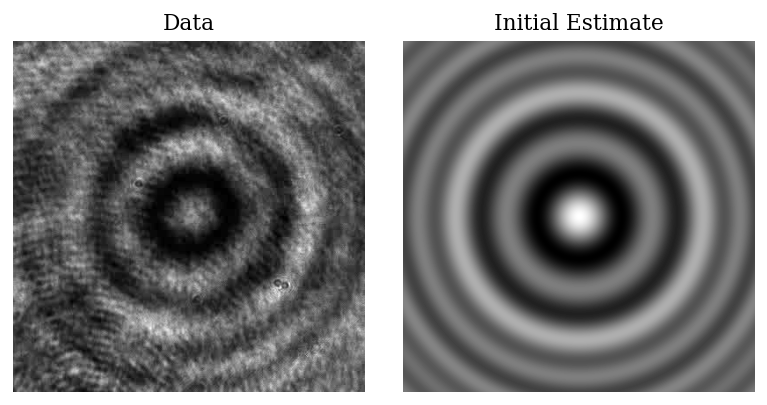

In [41]:
# First guess
# Order = radius, index, z
fitter.make_guess(3.7, 1.39, 80, show_estimate = True)

npixels = 159998
x_p = 202.6405 +- 0.0298
y_p = 196.4664 +- 0.0317
z_p = 1276.7664 +- 0.7099
a_p = 3.4475 +- 0.0033
n_p = 1.4002 +- 0.0001
chisq = 2.79


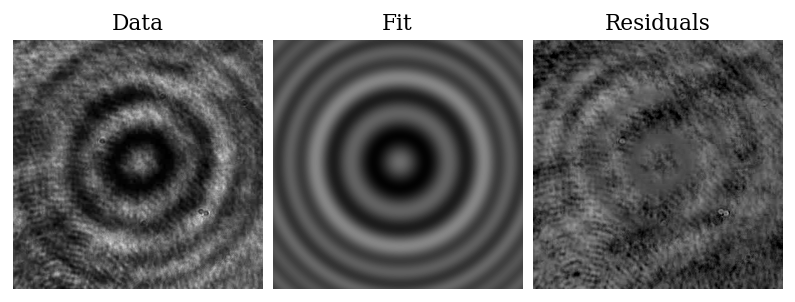

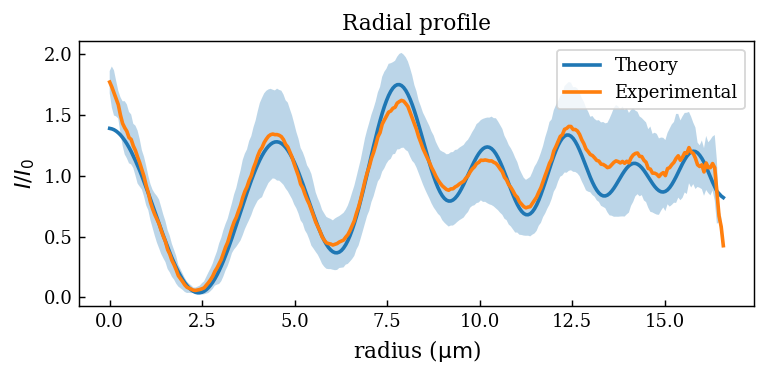

Distance to the objective (in um) = 
74.03968264891776


In [42]:
# Fit the first image 
# vary = ['x_p', 'y_p', 'z_p', 'a_p']
vary = ['x_p', 'y_p', 'z_p', "a_p", "n_p"]
fitter.set_vary(vary)
result = fitter.optimize(report = True, present=True, radial_profile = True)
print('Distance to the objective (in um) = ')
print(result['z_p'] * calib)

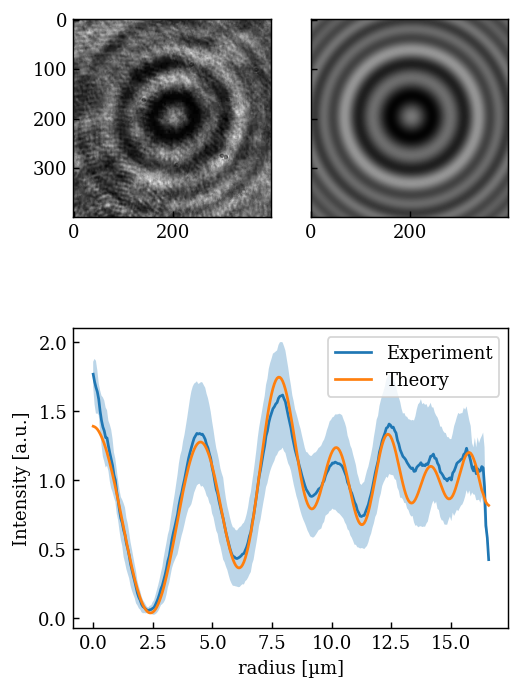

In [43]:
# Summary plot and save

fit_data = {}

fig = plt.figure(figsize=(cm2inch(10),cm2inch(15)))
fig.subplots_adjust(left=0.14, bottom=.12, right=.99, top=.98)

plt.subplot(2,2,1)
plt.imshow(fitter.feature.data, cmap = "gray", vmin=0, vmax=3)

fit_data["exp_image"] = fitter.feature.data

plt.subplot(2,2,2)
plt.imshow(fitter.feature.hologram().reshape(fitter.shape), cmap = "gray", vmin=0, vmax=3)
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])

fit_data["th_image"] = fitter.feature.hologram().reshape(fitter.shape)

from pylorenzmie.utilities import azistd
center = (fitter.feature.optimize()['x_p'], fitter.feature.optimize()['y_p'])
expe_avg, expe_std = azistd(fitter.feature.data, center)
r_exp = np.arange(len(expe_avg)) * fitter.ins.magnification
th_avg, th_std = azistd(fitter.feature.hologram(), center)
r_th = np.arange(len(th_avg)) * fitter.ins.magnification

plt.subplot(2,2,(3,4))
plt.plot(r_exp, expe_avg, label="Experiment")
plt.fill_between(r_exp, expe_avg - expe_std, expe_avg + expe_std, alpha = 0.3)
plt.plot(r_th, th_avg, label="Theory")
plt.legend()
plt.xlabel("radius [µm]")
plt.ylabel("Intensity [a.u.]")

fit_data["expe_avg"] = expe_avg
fit_data["expe_std"] = expe_std
fit_data['r_exp'] = r_exp

fit_data["th_avg"] = th_avg
fit_data["th_std"] = th_std
fit_data['r_th'] = r_th

plt.savefig("first_im_fig_vid_{0}.pdf".format(foldername))
plt.show()

savemat('first_im_data_vid_{0}.mat'.format(foldername), fit_data)

In [44]:
## Fit images to determine r-n
fitter.fit_video(
    vid = vid, savefile="find_nr.dat", 
    xc = x_center ,yc = y_center, h=h, 
    n_start=n_start, n_end=n_start+3000, 
    method = "lm", dark_count_mode="min", loss="linear", percentpix = 0.5, 
    update_mask=True, moving_background=False, 
)

100%|███████████████████████████████████████| 3000/3000 [07:50<00:00,  6.37it/s]


In [45]:
# Get data from the fits
n_r = np.fromfile("find_nr.dat", dtype=np.float64)
n_r = n_r.reshape(len(n_r)//5,5)
# n_r is an array. 
# Lines = different images 
# Columns = x, y, z, rp, np
r = n_r[:,3]
n = n_r[:,4]

Text(0, 0.5, 'Radius')

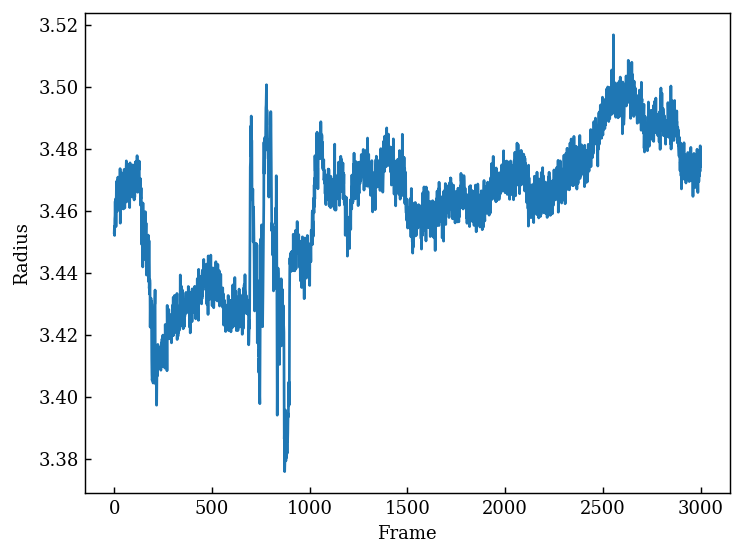

In [46]:
plt.plot(r)
plt.xlabel('Frame')
plt.ylabel('Radius')

Text(0, 0.5, 'z')

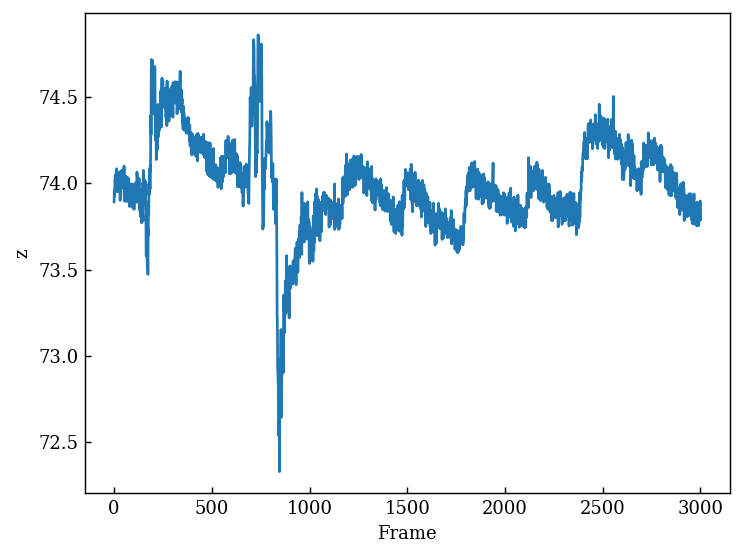

In [47]:
plt.plot(n_r[:,2]*calib)
plt.xlabel('Frame')
plt.ylabel('z')

/home/brownianxgames/miniconda3/envs/pylorenzmie-2/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Radius')

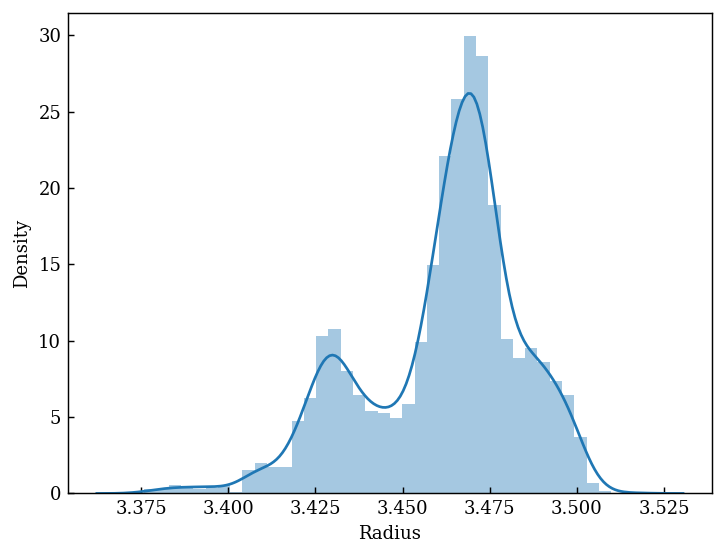

In [48]:
sns.distplot(r)
plt.xlabel('Radius')

Text(0, 0.5, 'Radius')

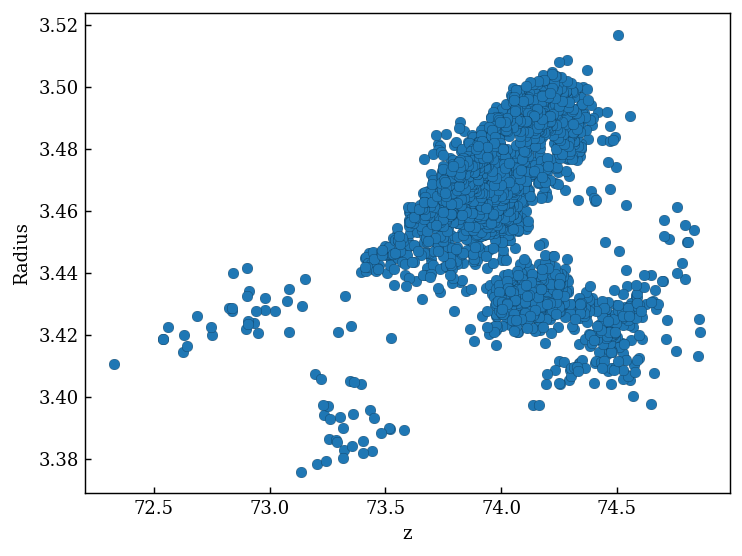

In [49]:
plt.plot(n_r[:,2]*calib, n_r[:,3], 'o')
plt.xlabel('z')
plt.ylabel('Radius')

Text(0, 0.5, 'Refractive index')

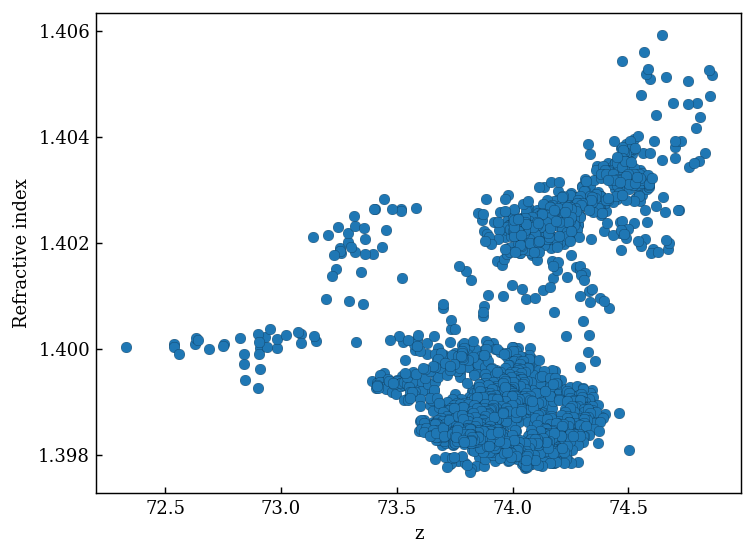

In [50]:
plt.plot(n_r[:,2]*calib, n_r[:,4], 'o')
plt.xlabel('z')
plt.ylabel('Refractive index')

In [51]:
# plt.plot(n_r[:, 3]**-1, n_r[:,4])

Text(0.5, 0, 'Radius [$\\mathrm{\\mu m}$]')

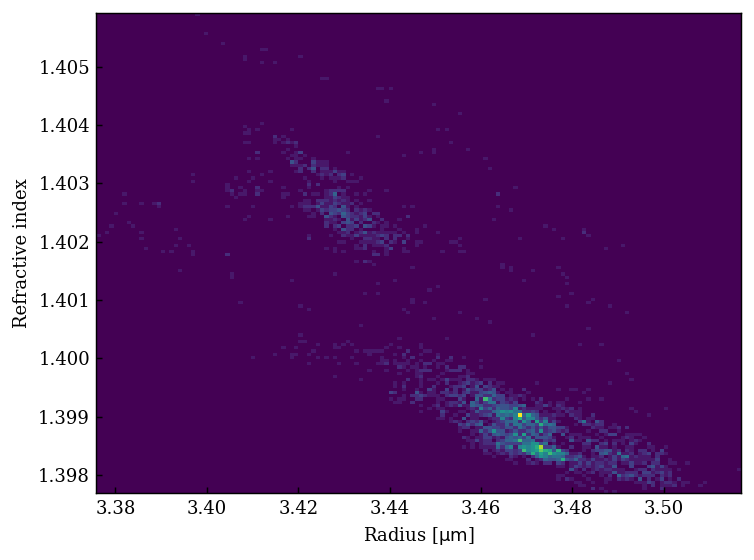

In [52]:
H, xedges, yedges = np.histogram2d(n, r, bins=100)
H = H.T  # Let each row list bins with common y range.


plt.hist2d(r,n, bins = 150)
plt.ylabel("Refractive index")
plt.xlabel("Radius [$\mathrm{\mu m}$]")



Text(0, 0.5, 'Refractive index')

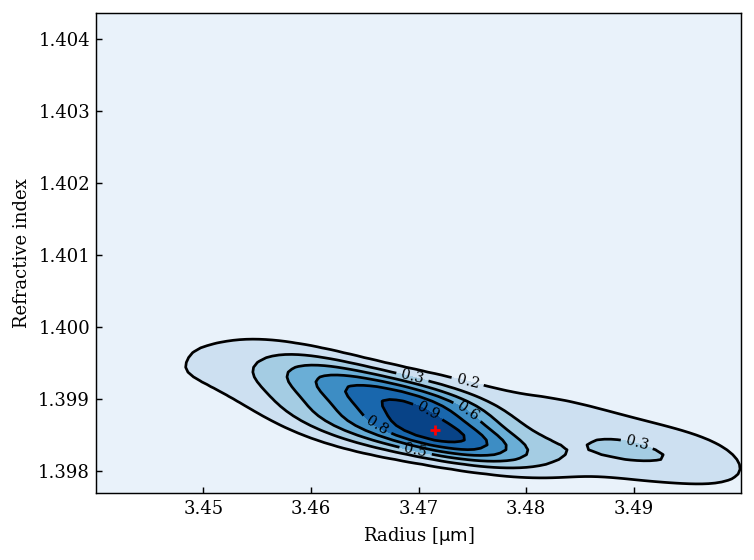

In [53]:
# Plot the 2D kernel histogram

# Choose the range of r to plot
rmin = 3.44
rmax = 3.50

import numpy as np
import matplotlib.pyplot as pl
import scipy.stats as st

data = np.random.multivariate_normal((0, 0), [[0.8, 0.05], [0.05, 0.7]], 100)
x = r[(r>rmin) & (r<rmax)]
y = n[(r>rmin) & (r<rmax)]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
f = f/np.max(f)

fig = plt.figure()
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k', levels=6)
# Label plot
ax.clabel(cset, inline=1, fontsize=8, fmt="%1.1f")
plt.scatter(xx[np.where(f == 1)],yy[np.where(f == 1)], color = "red", marker="+")
ax.set_xlabel("Radius [$\mathrm{\mu m}$]")
ax.set_ylabel("Refractive index")
# plt.title("KDE r n")

#pl.show()



In [54]:
print(" n determined with : mu={0}, sigma={1}".format(np.mean(yy[np.where(f == 1)]), np.std(yy[np.where(f > 0.2)])))
print(" r determined with : mu={0}, sigma={1}".format(np.mean(xx[np.where(f == 1)]), np.std(xx[np.where(f > 0.2)])))


mu_n, sigma_n = np.mean(yy[np.where(f == 1)]), np.std(yy[np.where(f > 0.2)])
mu_r, sigma_r = np.mean(xx[np.where(f == 1)]), np.std(xx[np.where(f > 0.2)])

# print(" n determined with : mu={0}, sigma={1}".format(np.mean(n), np.std(n)))
# mu_n, sigma_n = np.mean(n), np.std(n)

 n determined with : mu=1.3985623626162662, sigma=0.0004550211906185437
 r determined with : mu=3.471533998104464, sigma=0.011831248367972615


In [55]:
# If you want to input manually from another video

# mu_n = 1.4594286691500764
# mu_r = 1.395363112872611
# print(mu_n)
# print(mu_r)

In [56]:
txt_rp = str(np.round(mu_r, 4))
txt_rp = txt_rp.replace('.', 'p')

txt_np = str(np.round(mu_n, 4))
txt_np = txt_np.replace('.', 'p')

In [57]:
vidsavename = 'traj_rp_{0}_np_{1}_vid_{2}'.format(txt_rp, txt_np, foldername)

In [58]:
vidsavename

'traj_rp_3p4715_np_1p3986_vid_6'

In [59]:
h

400

In [60]:
# Fit the whole x, y, z of t
import warnings
warnings.filterwarnings('ignore')
vary = ['x_p', 'y_p', 'z_p']
#del fitter
h = h
im_c = fit.crop(image, int(x_center), int(y_center), int(h))
bk_c = fit.crop(vid.background, int(x_center), int(y_center), int(h))
cropped = utilities.normalize(im_c,bk_c, dark_count = np.min(im_c))
cropped = cropped / np.mean(cropped)
fitter = fit.fitting(cropped,wavelength,calib, n_m = n_m, percentpix=0.1, mask="fast", double_precision = False)
fitter.make_guess(mu_r,mu_n,result["z_p"]*calib, show_estimate = False)
fitter.set_vary(vary)
fitter.fit_video(
    vid = vid,
    savefile=vidsavename+'.dat',
    xc = x_center ,yc= y_center, h=h, 
    n_start=n_start, n_end=nb_image, 
    method = "lm", loss ="linear", dark_count_mode="min", percentpix = 0.3, 
    moving_background=False, 
)



100%|█████████████████████████████████| 149433/149433 [1:35:09<00:00, 26.17it/s]


In [73]:
import numpy as np
import matplotlib.pyplot as plt

In [74]:
filename = glob.glob("traj*.dat")[0] # Get back data
traj = np.fromfile(filename, dtype=np.float64)
traj = traj.reshape(len(traj)//3,3) * 1e-6 * calib # in SI
data = {
    "x": traj[:,0], 
    "y": traj[:,1], 
    "z": traj[:,2], 
    'filename': glob.glob("*.mp4")[0], 
    'fps': fps, 
}

savemat(filename[:-4] +'.mat', data) # Save .mat

In [75]:
traj = traj[::1,::]

In [76]:
x = traj[:,0]
y = traj[:,1]
z = traj[:,2]
r = np.sqrt((x-x[0])**2+(y-y[0])**2)

Text(0, 0.5, 'z')

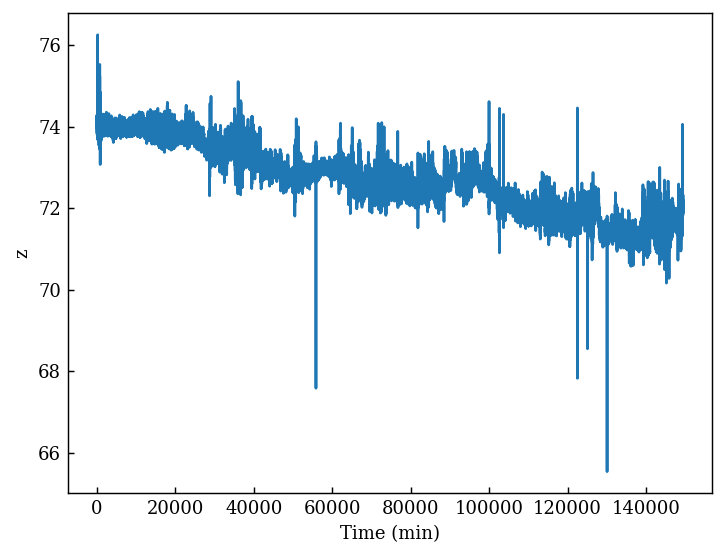

In [77]:
plt.figure()
plt.plot(np.arange(len(traj[:,2])), traj[:,2] * 1e6)
plt.xlabel('Time (min)')
plt.ylabel('z')

Text(0, 0.5, 'x')

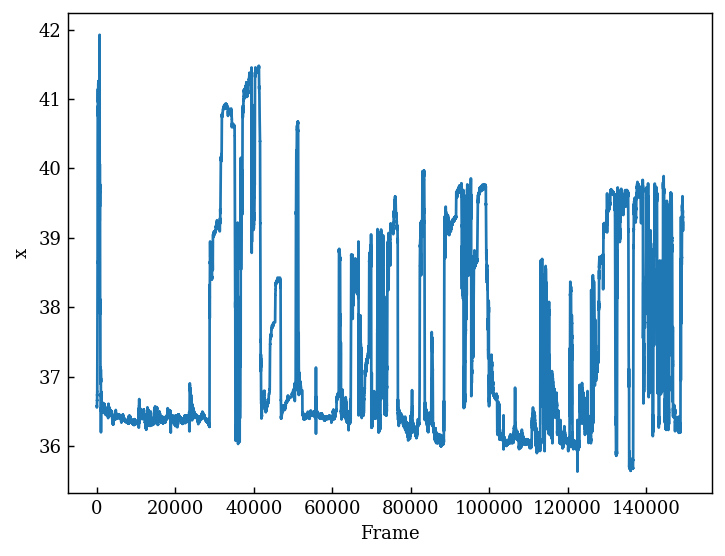

In [78]:
plt.figure()
plt.plot(traj[:,0] * 1e6)
plt.xlabel('Frame')
plt.ylabel('x')

Text(0, 0.5, 'y')

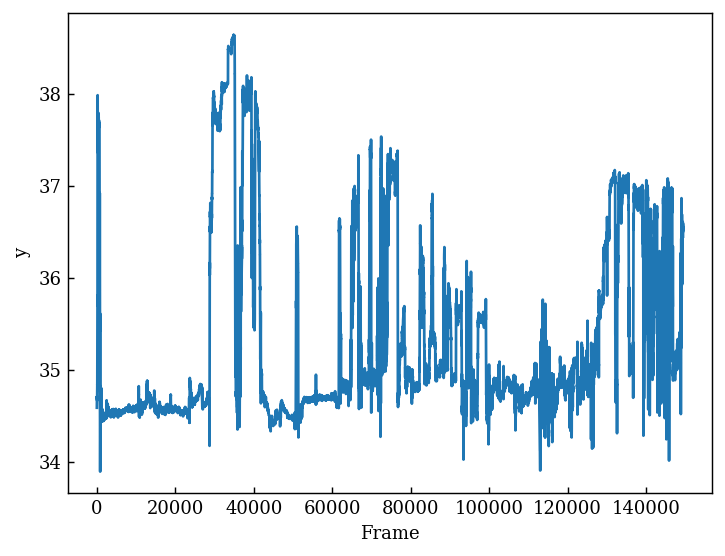

In [79]:
plt.figure()
plt.plot(traj[:,1] * 1e6)
plt.xlabel('Frame')
plt.ylabel('y')

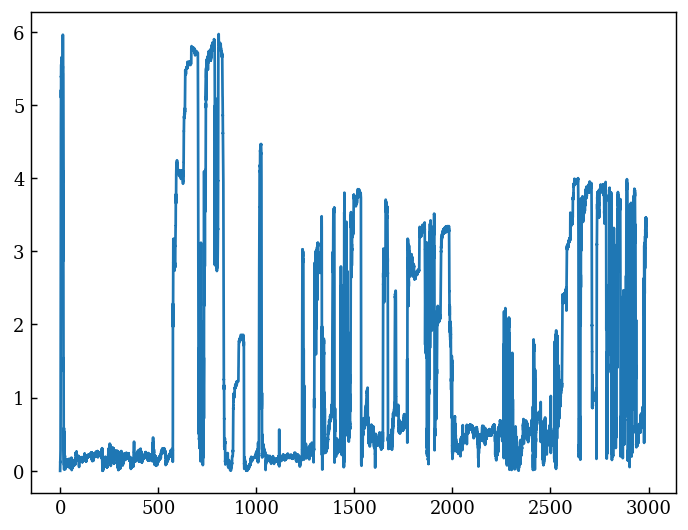

In [80]:
plt.plot(np.arange(len(r)) / fps, r * 1e6)

Text(0, 0.5, 'y')

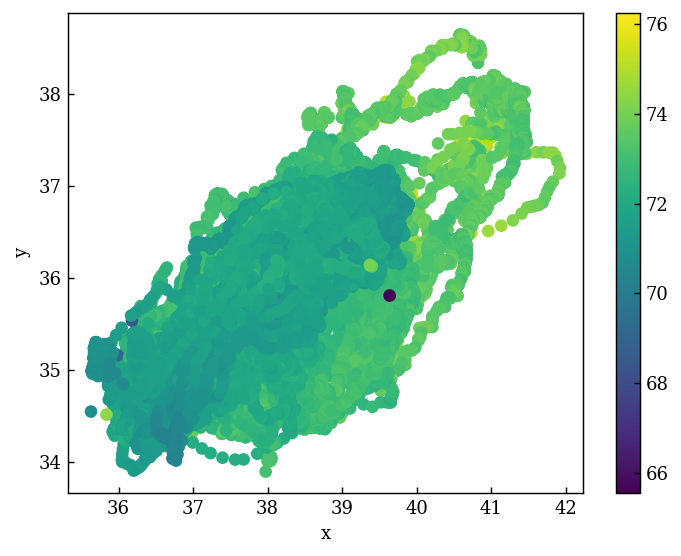

In [81]:
plt.scatter(traj[:,0] * 1e6, traj[:,1]* 1e6,cmap='viridis',c=z*1e6)#np.arange(len(r)) / fps)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

In [82]:
df = np.concatenate(
    (np.linspace(1, 10, 10), np.linspace(10, 100, 100), 
    np.linspace(100, 100000, 100), 
    )
)

dt = df / fps

In [83]:
msdx = np.zeros(len(df))
msdz = np.zeros(len(df))

for i, f in enumerate(df):
    f = int(f)
    msdx[i] = np.nanmean((traj[f:,0] - traj[:-f,0])**2)
    msdz[i] = np.nanmean((traj[f:,2] - traj[:-f,2])**2)

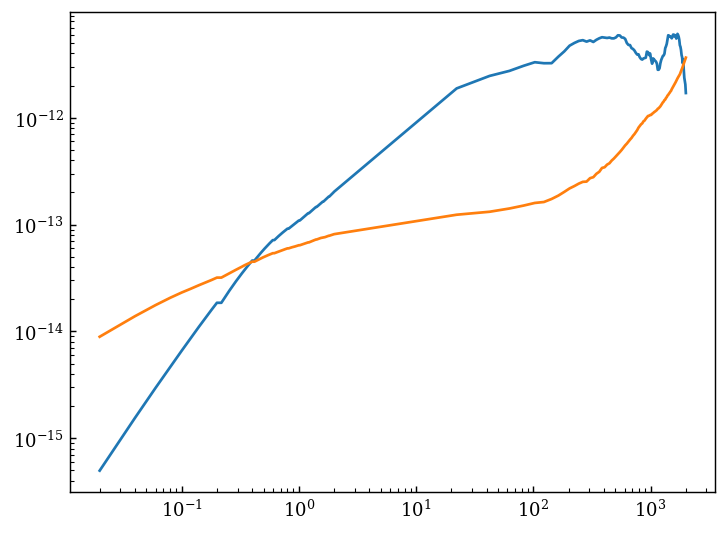

In [84]:
plt.loglog(dt, msdx)
plt.plot(dt, msdz)